# 📊 Анализ оттока клиентов телеком-компании

В этом проекте проведен анализ оттока клиентов компании, начиная с изучения данных, их обработки, построения моделей и оценки финальных результатов. Цель — построить модель, которая сможет точно предсказывать вероятность ухода клиента, при этом акцент на снижении ошибок второго рода (лучше классифицировать клиентов, которые уйдут).

In [1]:
# импорт библиотек и метрик
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st


from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score, mean_absolute_error)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import clone

import time
from tqdm import tqdm
import re

from sklearn.datasets import fetch_california_housing

from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier

from scipy.stats import chi2_contingency

from IPython.display import display, Markdown

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.utils.validation')

# 📁 Загрузка данных и первичный анализ

In [2]:
data = pd.read_csv('Churn.csv')

In [3]:
display(data.head(10))
data.info()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


🔍 **Вывод:** В датасете присутствуют как числовые, так и категориальные признаки. Целевой признак — `churn`, принимает значения `'Yes'` и `'No'`.

In [4]:
data.drop(columns=['customerID'], inplace=True)

In [5]:
def to_snake_case(name):
    import re
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name)
    return name.lower()

data.columns = [to_snake_case(col) for col in data.columns]

display(data.head(0))

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn


In [6]:
print('Количество пропусков в каждом из столбцов:')
print(data.isna().sum())

Количество пропусков в каждом из столбцов:
gender               0
senior_citizen       0
partner              0
dependents           0
tenure               0
phone_service        0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
contract             0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
dtype: int64


In [7]:
print(f'Количество дубликатов: {data.duplicated().sum()}')

Количество дубликатов: 22


In [8]:
data = data.drop_duplicates()

In [9]:
data.loc[:, 'senior_citizen'] = data['senior_citizen'].replace({0: 'No', 1: 'Yes'})

/var/folders/1j/wgf74c1d3f116n7z14dqwqcr0000gn/T/ipykernel_91758/2299167596.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['No' 'No' 'No' ... 'No' 'Yes' 'No']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, 'senior_citizen'] = data['senior_citizen'].replace({0: 'No', 1: 'Yes'})


In [10]:
for col in data.select_dtypes(include='object').columns:
    print(f"Столбец: {col}")
    print(data[col].unique())
    print("-" * 50)

Столбец: gender
['Female' 'Male']
--------------------------------------------------
Столбец: senior_citizen
['No' 'Yes']
--------------------------------------------------
Столбец: partner
['Yes' 'No']
--------------------------------------------------
Столбец: dependents
['No' 'Yes']
--------------------------------------------------
Столбец: phone_service
['No' 'Yes']
--------------------------------------------------
Столбец: multiple_lines
['No phone service' 'No' 'Yes']
--------------------------------------------------
Столбец: internet_service
['DSL' 'Fiber optic' 'No']
--------------------------------------------------
Столбец: online_security
['No' 'Yes' 'No internet service']
--------------------------------------------------
Столбец: online_backup
['Yes' 'No' 'No internet service']
--------------------------------------------------
Столбец: device_protection
['No' 'Yes' 'No internet service']
--------------------------------------------------
Столбец: tech_support
['No' 'Ye

In [11]:
data = data.copy()
data['total_charges'] = data['total_charges'].replace(' ', np.nan)
data['total_charges'] = data['total_charges'].astype('float')
print(data['total_charges'].isna().sum())  

11


In [12]:
missing_total_idx = data[data['total_charges'].isna()].index

data.loc[missing_total_idx, 'total_charges'] = (
    data.loc[missing_total_idx, 'monthly_charges'] * data.loc[missing_total_idx, 'tenure']
)

print(data.loc[missing_total_idx, ['monthly_charges', 'tenure', 'total_charges']])

      monthly_charges  tenure  total_charges
488             52.55       0            0.0
753             20.25       0            0.0
936             80.85       0            0.0
1082            25.75       0            0.0
1340            56.05       0            0.0
3331            19.85       0            0.0
3826            25.35       0            0.0
4380            20.00       0            0.0
5218            19.70       0            0.0
6670            73.35       0            0.0
6754            61.90       0            0.0


**Вывод по предобработке данных:**
- Названия столбцов приведены к корректному стилю
- Обработаны пропуски
- Исключены явные дубликаты
- Неявные дубликаты не обнаружены

# 🔍 Исследовательский анализ данных (EDA)

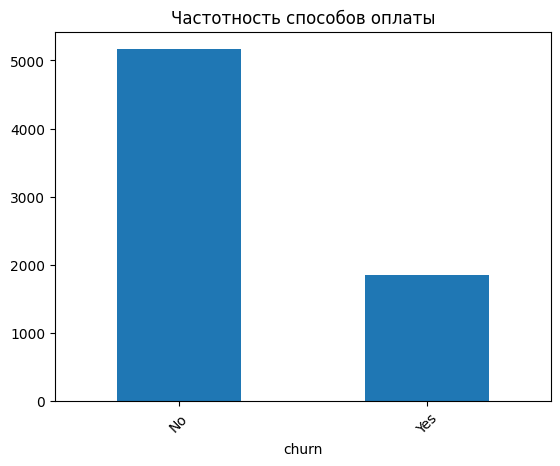

churn
No     5164
Yes    1857
Name: count, dtype: int64

In [13]:
data['churn'].value_counts().plot(kind='bar')
plt.title('Частотность способов оплаты')
plt.xticks(rotation=45)
plt.show()
data['churn'].value_counts()

⚠️ **Наблюдение:** Целевая переменная имеет выраженный дисбаланс классов: клиентов, остающихся - больше. Это стоит учесть при построении моделей — например, использовать взвешивание классов.

## 📈 Визуализация категориальных признаков

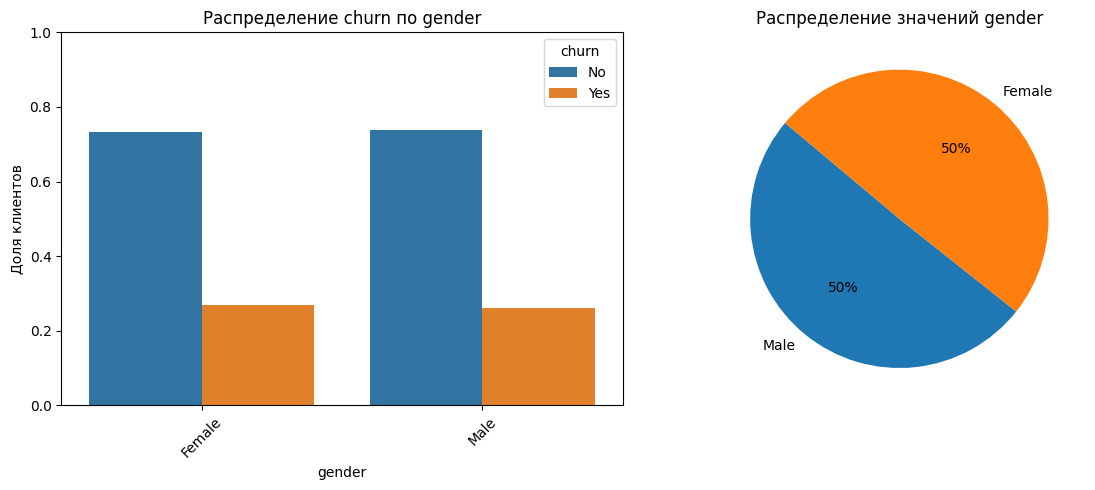

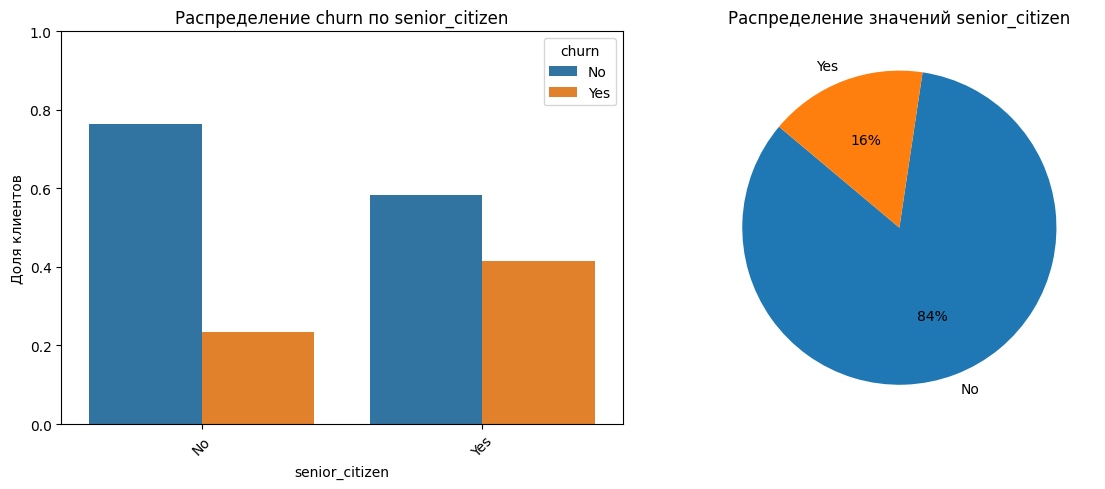

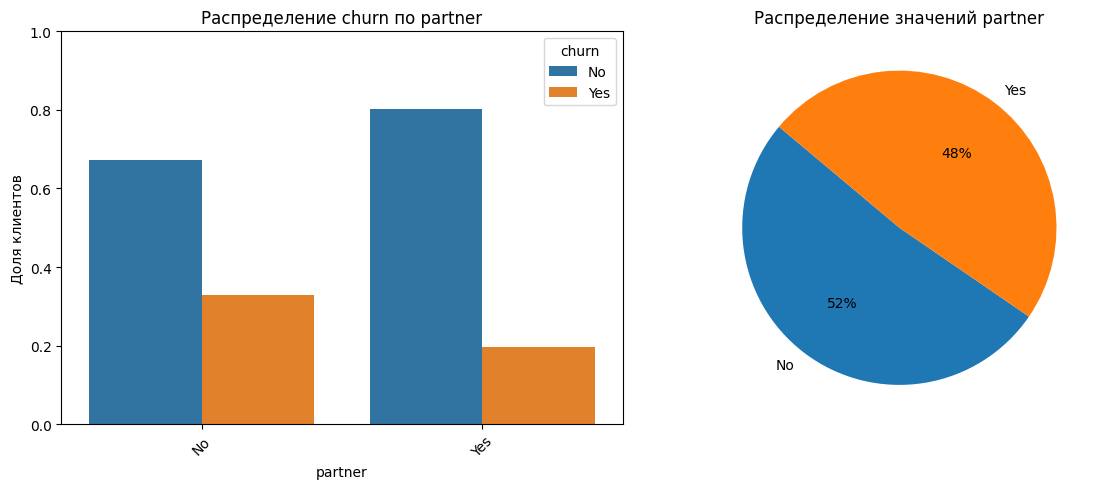

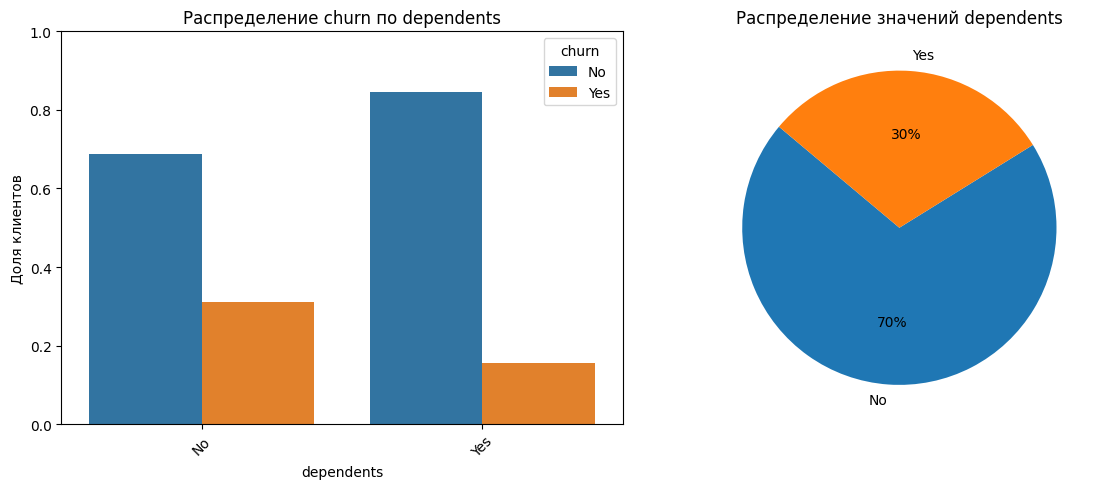

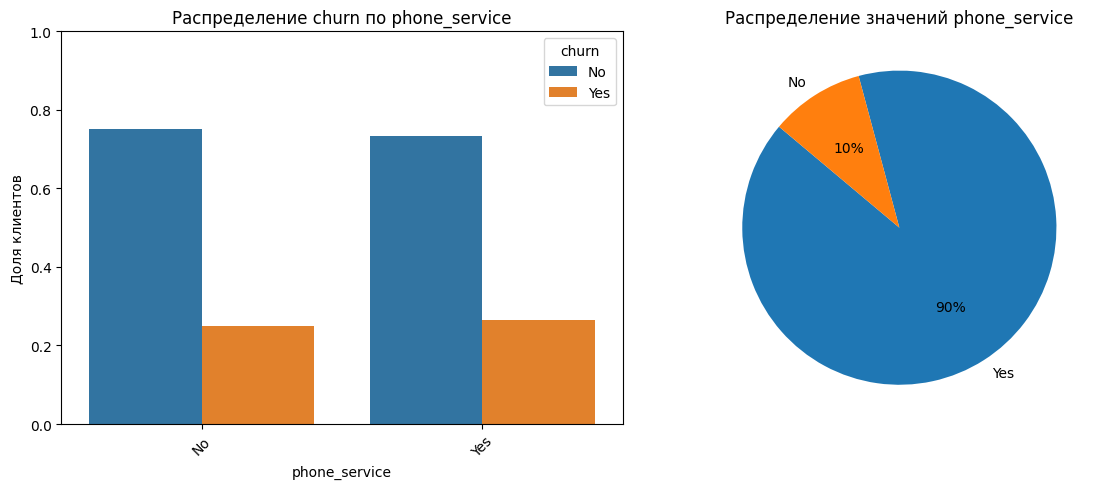

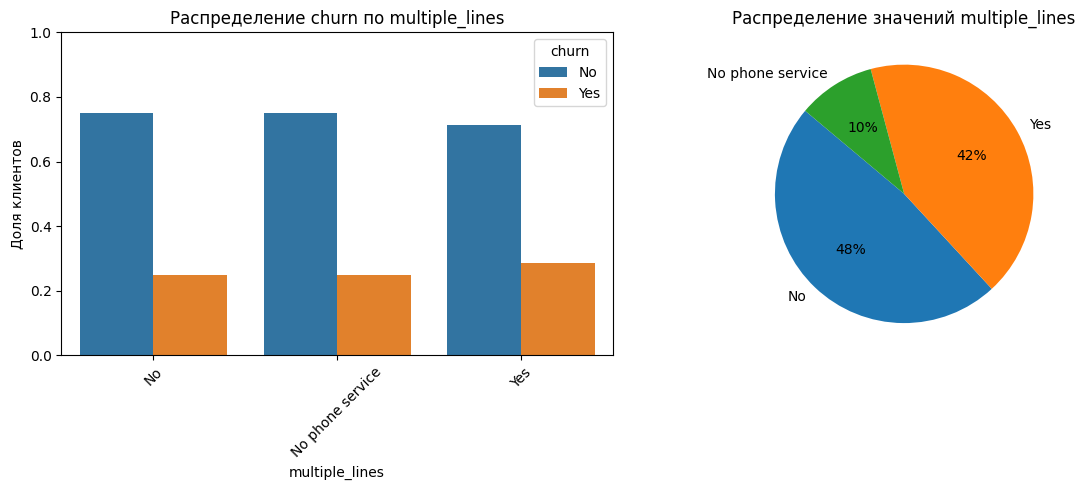

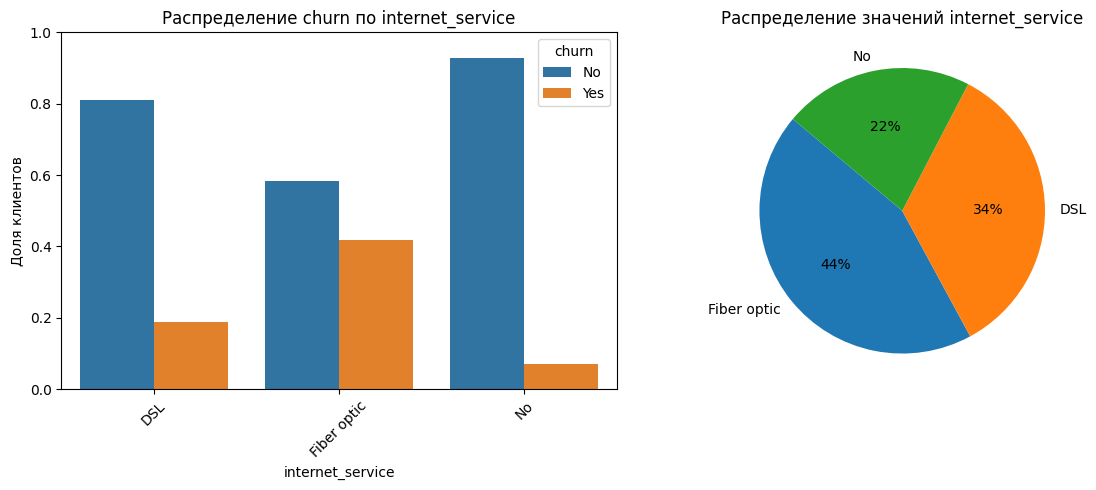

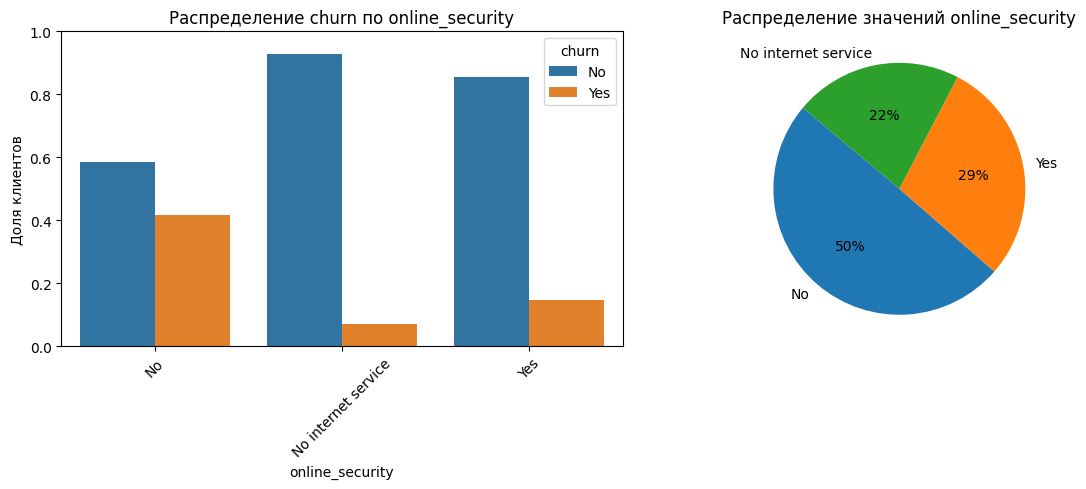

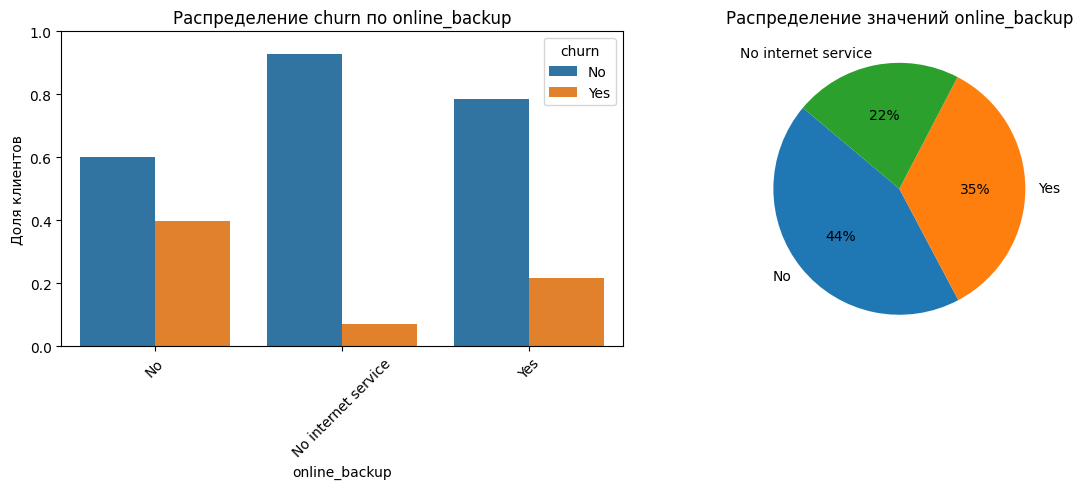

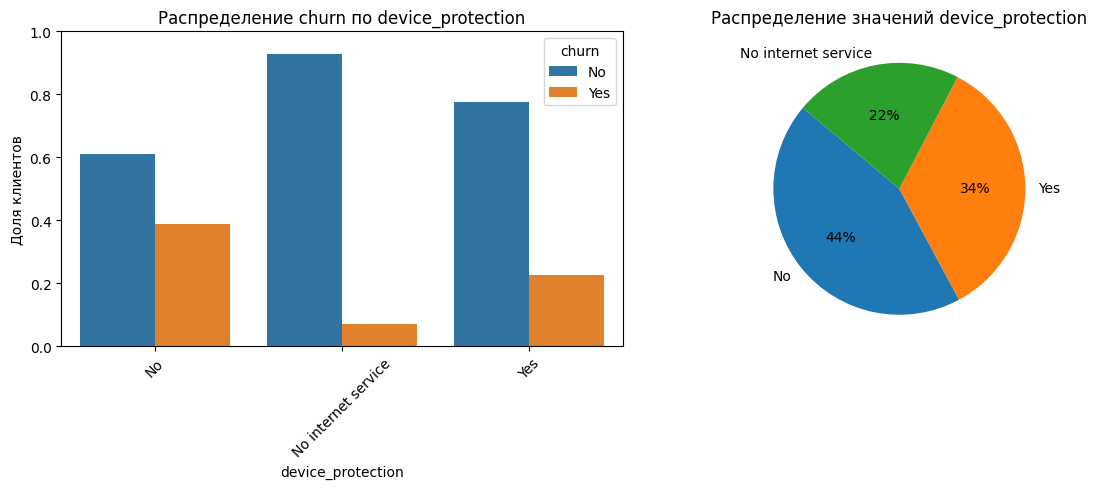

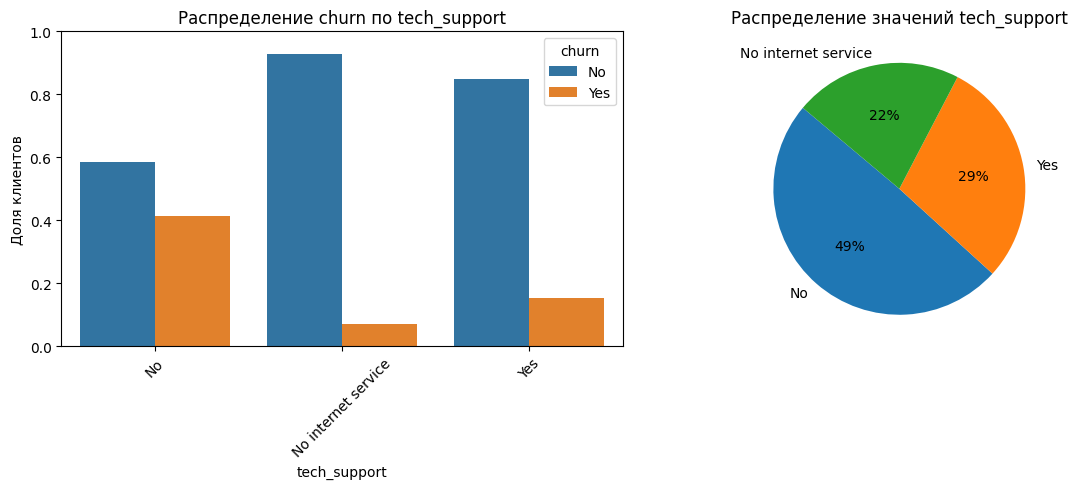

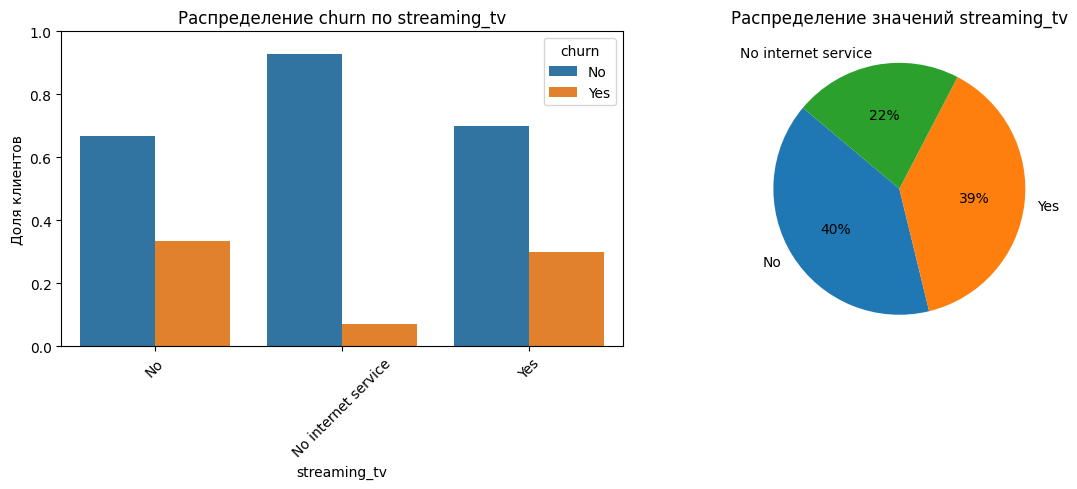

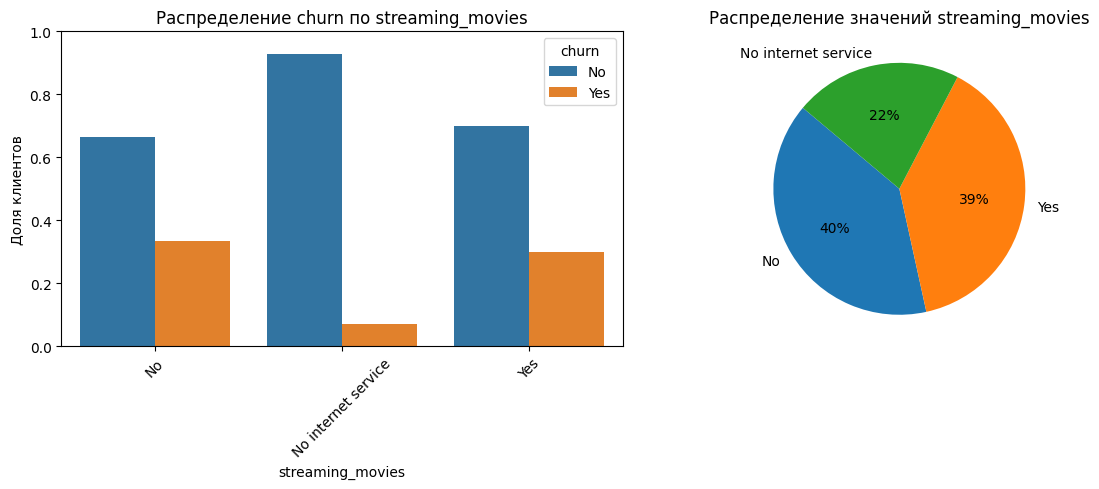

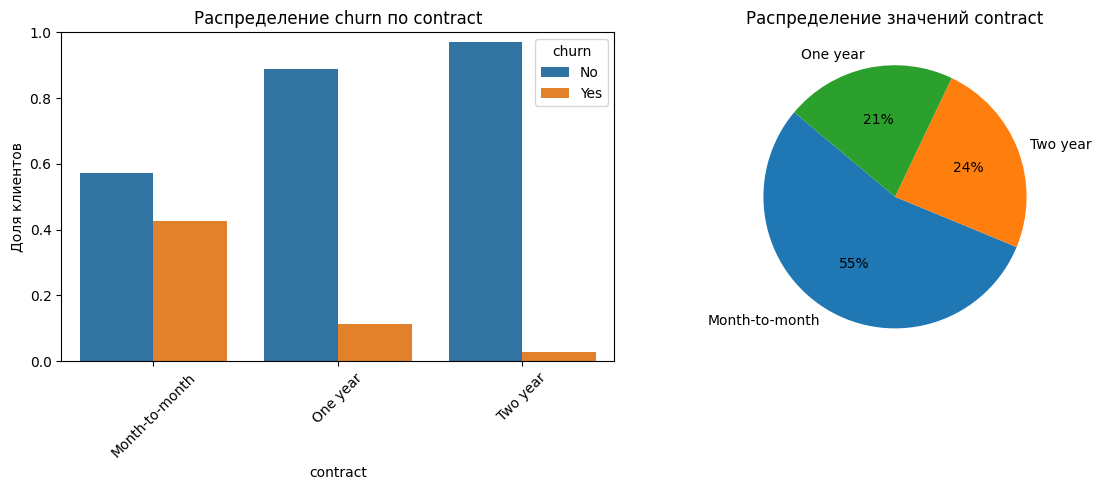

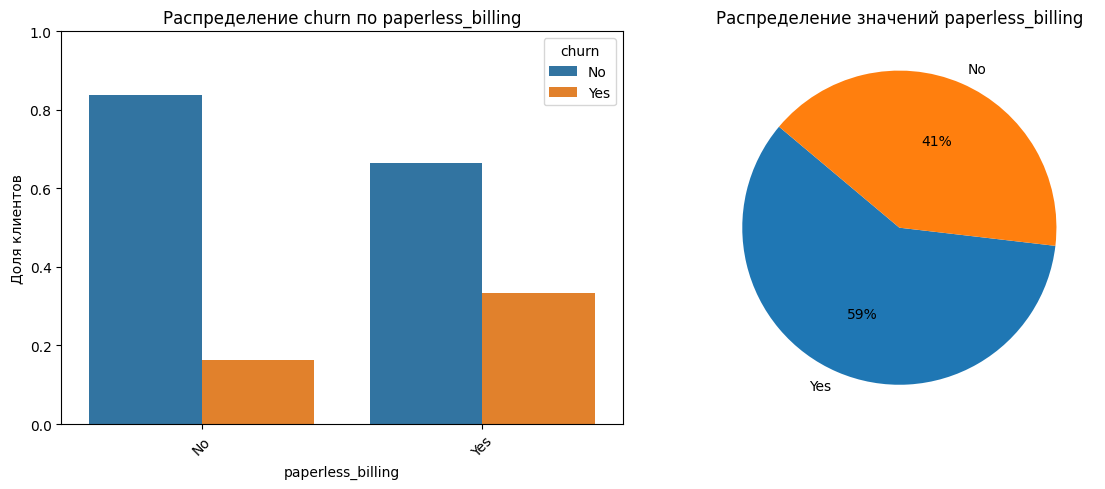

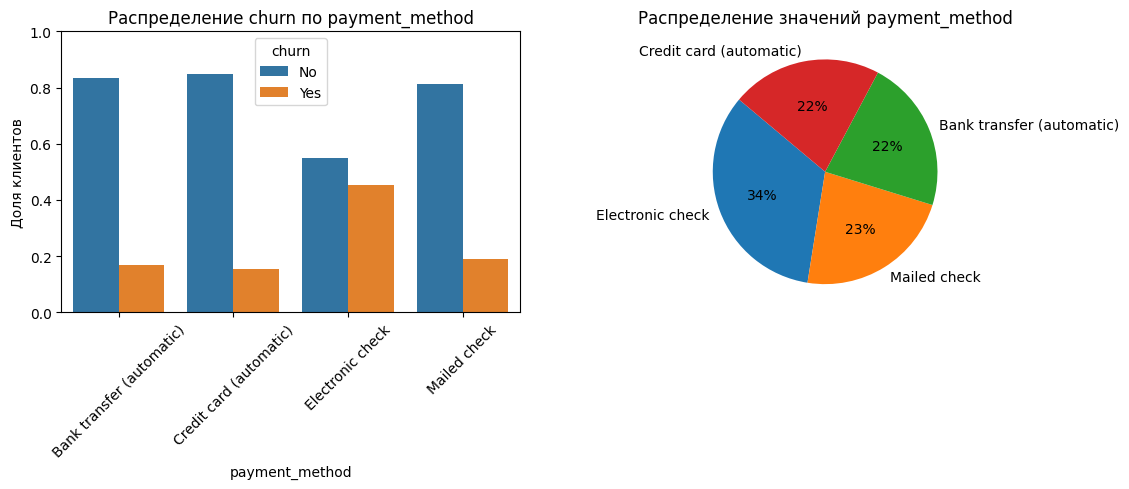

In [14]:
categorical_cols = data.select_dtypes(include='object').columns.drop('churn')

for col in categorical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    churn_dist = (
        data.groupby(col)['churn']
        .value_counts(normalize=True)
        .rename('proportion')
        .reset_index()
    )

    sns.barplot(
        x=col,
        y='proportion',
        hue='churn',
        data=churn_dist,
        ax=axes[0]
    )
    axes[0].set_title(f'Распределение churn по {col}')
    axes[0].set_ylabel('Доля клиентов')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].set_ylim(0, 1) 

    pie_counts = data[col].value_counts()
    wedges, texts, autotexts = axes[1].pie(
        pie_counts,
        labels=pie_counts.index,
        autopct='%1.0f%%',
        startangle=140
    )
    axes[1].set_title(f'Распределение значений {col}')
    for text in texts + autotexts:
        text.set_fontsize(10)

    plt.tight_layout()
    plt.show()

**Вывод:**
- 1.	`gender`: отток почти одинаковый у мужчин и женщин — скорее всего, пол незначимый фактор.
- 2.	`partner` и `dependents`: люди без партнера и детей чаще уходят. Возможно, клиенты с семьей более стабильны.
- 3.	`internet_service`: наибольший отток у клиентов с *Fiber optic*. Это может быть связано с тарифами или качеством услуг.
- 4.	`online_security`, `tech_support`, `device_protection`: отсутствие этих опций — повышенный отток. Возможно, наличие этих сервисов повышает лояльность.
- 5.	`contract`: краткосрочные контракты сильно коррелируют с оттоком. Люди на *Month-to-month* уходят в разы чаще.
- 6.	`payment_method`: самый высокий отток у тех, кто платит через *Electronic check* — возможно, это менее удобный или менее надежный способ оплаты.


## 📊 Визуализация числовых признаков

In [15]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7021.0,32.469449,24.534965,0.00,9.00,29.00,55.0,72.00
monthly_charges,7021.0,64.851894,30.069001,18.25,35.75,70.40,89.9,118.75
total_charges,7021.0,2286.765026,2266.855057,0.00,403.35,1400.55,3801.7,8684.80


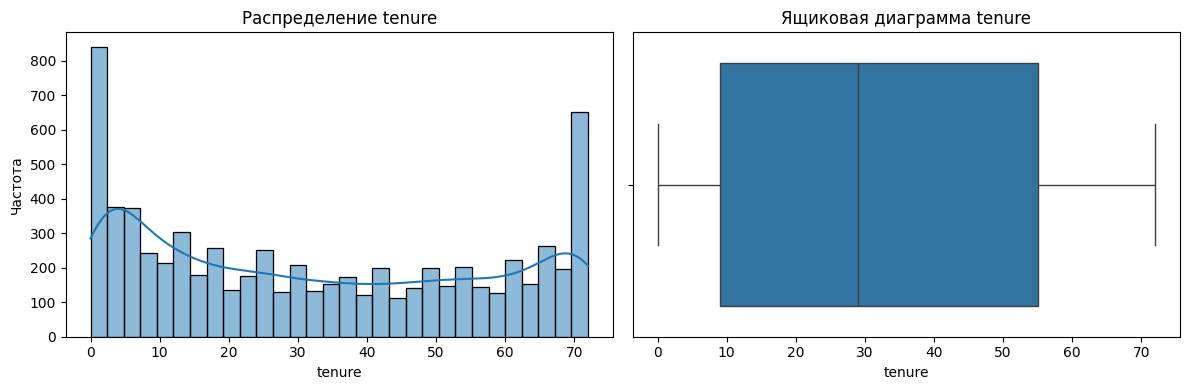

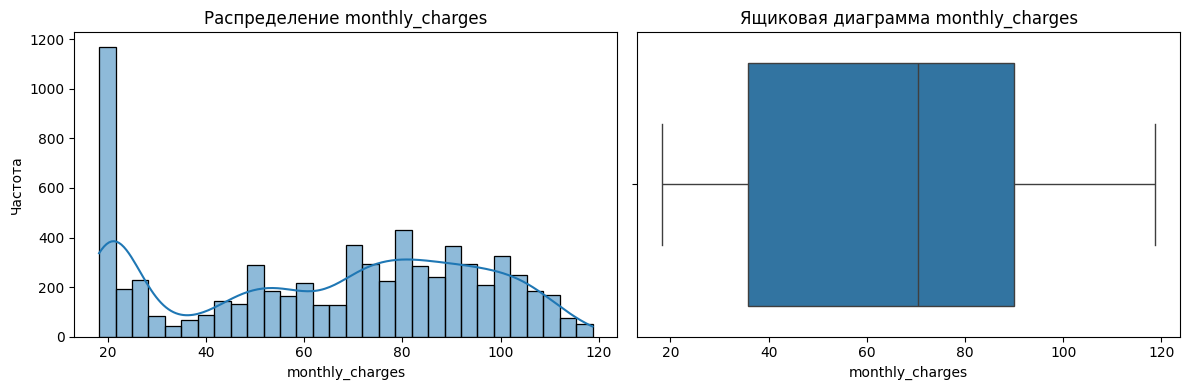

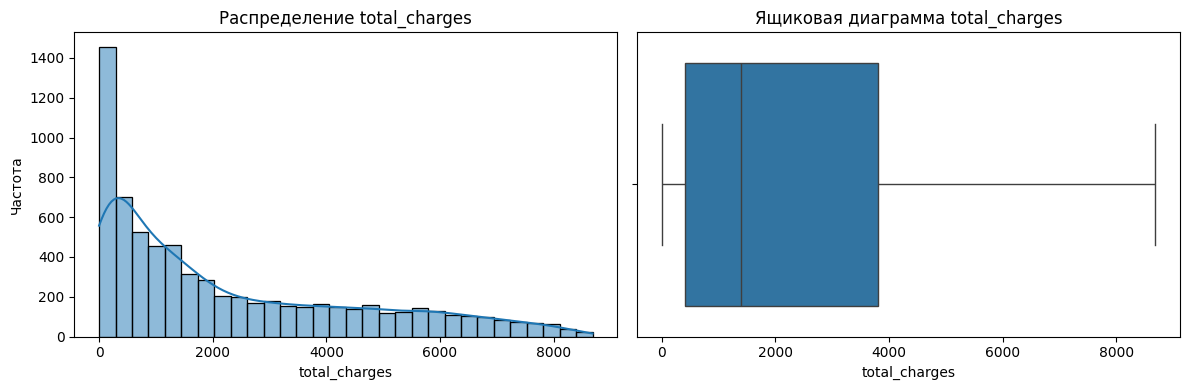

In [16]:
numerical_cols = data.select_dtypes(include='number').columns.drop('senior_citizen', errors='ignore')

for col in numerical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Гистограмма
    sns.histplot(data[col], bins=30, kde=True, ax=axes[0])
    axes[0].set_title(f'Распределение {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Частота')
    
    # Диаграмма размаха
    sns.boxplot(x=data[col], ax=axes[1])
    axes[1].set_title(f'Ящиковая диаграмма {col}')
    axes[1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

📈 **Вывод:** Распределения числовых признаков различны: `tenure` имеет пики в начале и в конце, `monthly_charges` почти равномерно с акцентом на нижней границе (18–30), небольшой пик в конце, `total_charges` распределен асимметрично. Явных выбросов не наблюдается.

# 🔗 Корреляционный анализ

/var/folders/1j/wgf74c1d3f116n7z14dqwqcr0000gn/T/ipykernel_91758/2208845377.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


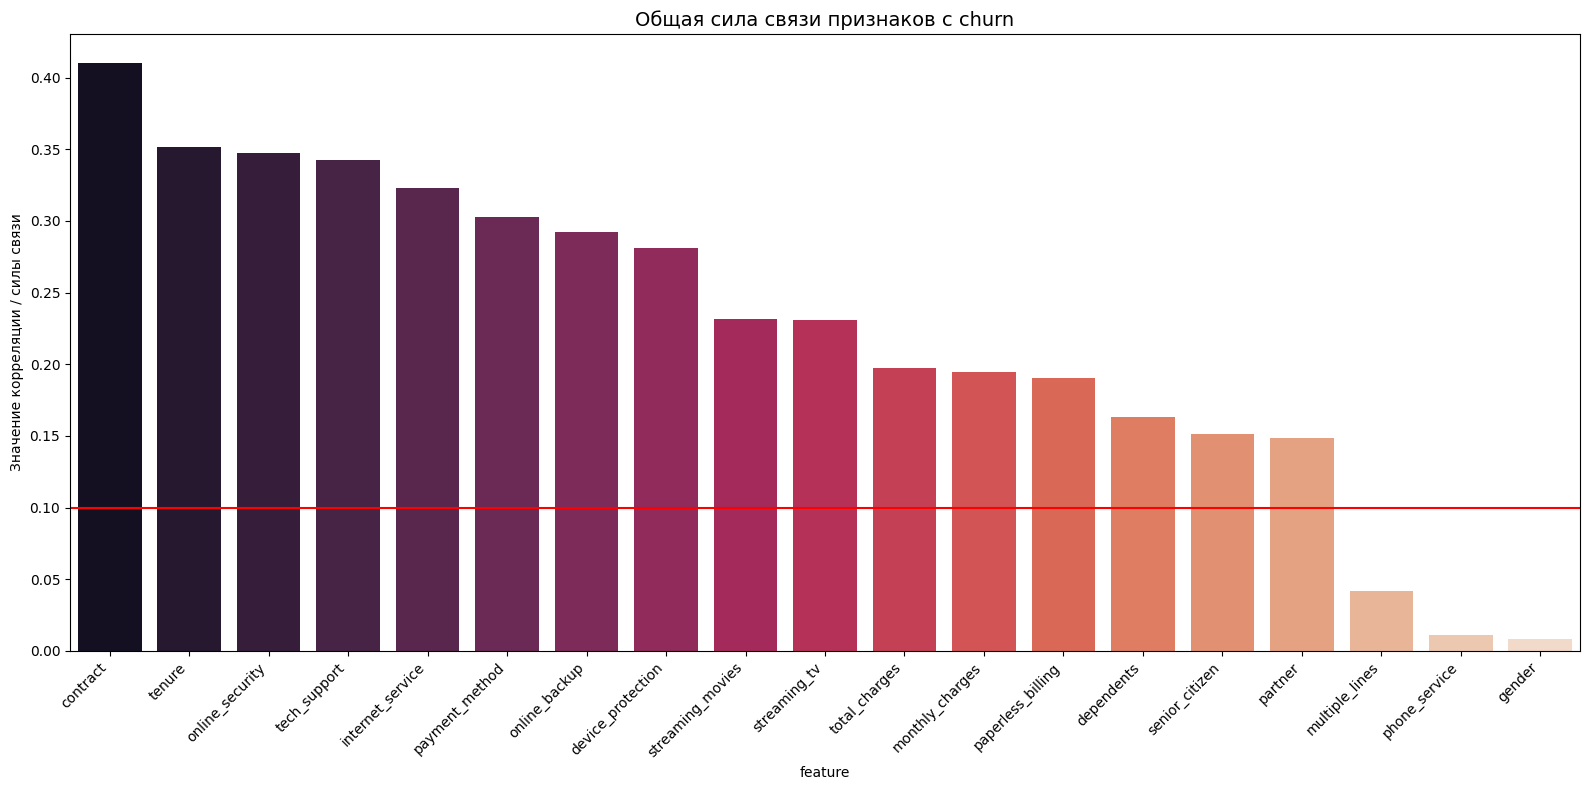

In [17]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k, r) - 1)))

data['churn_numeric'] = data['churn'].map({'No': 0, 'Yes': 1})

numeric_cols = data.select_dtypes(include='number').columns.drop('churn_numeric')
num_corr = data[numeric_cols].corrwith(data['churn_numeric']).abs()
num_corr = pd.DataFrame({'feature': num_corr.index, 'correlation': num_corr.values})

cat_cols = data.select_dtypes(include='object').columns.drop('churn')
cat_corr = {col: cramers_v(data[col], data['churn']) for col in cat_cols}
cat_corr = pd.DataFrame({'feature': list(cat_corr.keys()), 'correlation': list(cat_corr.values())})

all_corr = pd.concat([num_corr, cat_corr], ignore_index=True)
all_corr = all_corr.sort_values(by='correlation', ascending=False)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=all_corr,
    x='feature',
    y='correlation',
    palette=sns.color_palette('rocket', n_colors=len(all_corr)) 
)
plt.axhline(y=0.1, color='red', linestyle='-')
plt.xticks(rotation=45, ha='right')
plt.title('Общая сила связи признаков с churn', fontsize=14)
plt.ylabel('Значение корреляции / силы связи')
plt.tight_layout()
plt.show()

In [18]:
data = data.drop(['multiple_lines', 'phone_service', 'gender'], axis = 1)

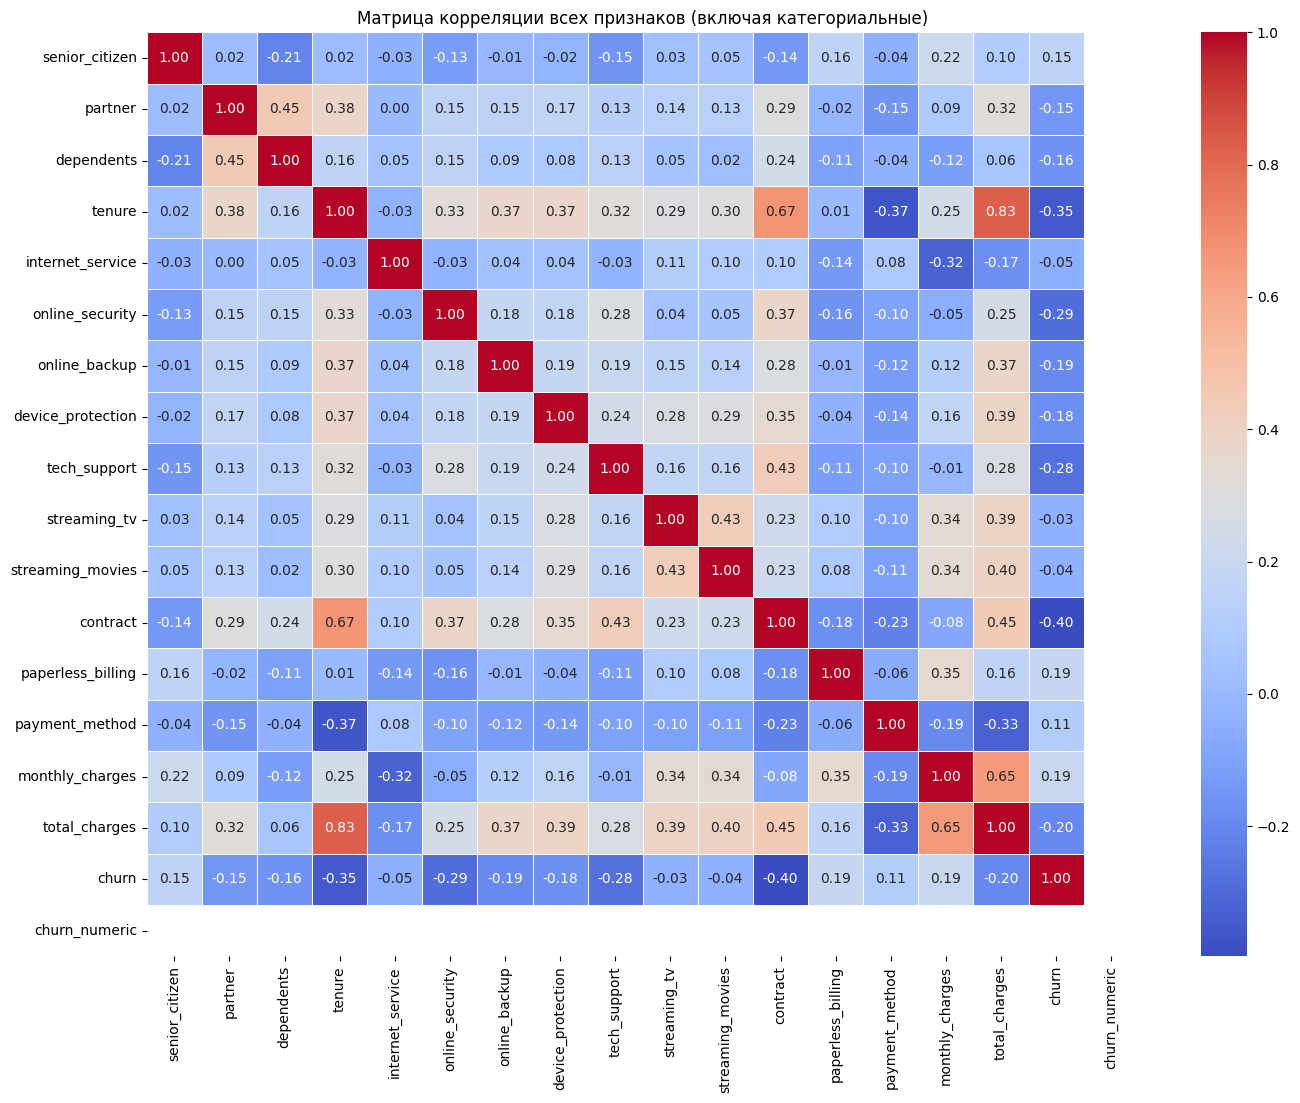

In [19]:
corr_data = data.copy()

cat_cols = corr_data.select_dtypes(include='object').columns
encoder = OrdinalEncoder()
corr_data[cat_cols] = encoder.fit_transform(corr_data[cat_cols])

corr_data['churn_numeric'] = corr_data['churn'].map({'No': 0, 'Yes': 1})

# Строим матрицу корреляции
corr_matrix = corr_data.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Матрица корреляции всех признаков (включая категориальные)")
plt.show()

🔗 **Вывод:** 
- Удалены признаки, которые коррелируют с целевым признаком меньше чем на 0.1
- Наибольшую корреляцию с оттоком показывают признаки `contract`, `tenure`, `online_security`, что подтверждает важность этих переменных в моделировании.

# 🧹 Подготовка данных

In [20]:
target = 'churn_numeric'

RANDOM_STATE = 42
TEST_SIZE = 0.2

X = data.drop(columns=['churn', 'churn_numeric']) 
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=TEST_SIZE, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)

In [21]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()

ord_columns = [data.columns.tolist()[-7]]
ohe_columns = list(set(categorical_cols) - set(ord_columns))
num_columns = X_train.select_dtypes(include='number').columns.tolist()

print(ohe_columns)
print(ord_columns)
print(num_columns)
print(data['contract'].unique())

['paperless_billing', 'payment_method', 'online_security', 'senior_citizen', 'partner', 'online_backup', 'tech_support', 'internet_service', 'streaming_tv', 'streaming_movies', 'device_protection', 'dependents']
['contract']
['tenure', 'monthly_charges', 'total_charges']
['Month-to-month' 'One year' 'Two year']


In [22]:
ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

ord_pipe = Pipeline([
    ('imputer1', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=[['Month-to-month', 'One year', 'Two year']],
                           handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('imputer2', SimpleImputer(strategy='most_frequent'))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', num_pipe, num_columns)
], remainder='drop')

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__min_samples_leaf': range(2, 5),
        'models__min_samples_split': range(2, 6),
    },
    {
        'models': [CatBoostClassifier(verbose=0)],
        'models__depth': [4, 6],
        'models__learning_rate': [0.03, 0.1],
        'models__iterations': [100, 200]
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1')],
        'models__C': range(1, 15),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [XGBClassifier(verbosity=0, use_label_encoder=False)],
        'models__n_estimators': [100, 200],
        'models__max_depth': [5, 10],
        'models__learning_rate': [0.05, 0.1]
    },
    {
        'models': [LGBMClassifier(verbose = -1)],
        'models__n_estimators': [100, 200],
        'models__max_depth': [5, 10],
        'models__learning_rate': [0.05, 0.1]
    }
]

# 🤖 Построение моделей и подбор гиперпараметров

In [23]:
grid = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=3, 
    scoring='roc_auc',
    n_jobs=-1
)
grid.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['paperless_billing',
                                                                          'payment_method',
                                                                          'online_security',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'online_backup',
                                                                          't...
                                                   monotone_constraints=None,
                                                   multi_strategy=None,
                                                   n_estimators=None,
                                                   n_jobs=None,
                                                   num_parallel_tree=None, ...)],
                          'models__learning_rate': [0.05, 0.1],
                          'models__max_depth': [5, 10],
                          'models__n_estimators': [100, 200]},
                         {'models': [LGBMClassifier(verbose=-1)],
                          'models__learning_rate': [0.05, 0.1],
                          'models__max_depth': [5, 10],
                          'models__n_estimators': [100, 200]}],
             scoring='roc_auc')

In [24]:
cv_results = pd.DataFrame(grid.cv_results_)

best_per_model = (
    cv_results
    .assign(model_name=cv_results['param_models'].apply(lambda x: x.__class__.__name__))
    .sort_values('mean_test_score', ascending=False)
    .drop_duplicates(subset='model_name', keep='first')
    [['model_name', 'params', 'mean_test_score']]
    .rename(columns={
        'model_name': 'Model',
        'params': 'Best Params',
        'mean_test_score': 'ROC AUC (CV)'
    })
    .reset_index(drop=True)
)

best_per_model = best_per_model.sort_values('ROC AUC (CV)', ascending=False).reset_index(drop=True)

display(best_per_model)

best_model_name = best_per_model.iloc[0]['Model']
display(Markdown(f"**Лучшая модель по метрике ROC AUC: `{best_model_name}`**"))

,Model,Best Params,ROC AUC (CV)
0,CatBoostClassifier,{'models': <catboost.core.CatBoostClassifier o...,0.849919
1,LogisticRegression,"{'models': LogisticRegression(penalty='l1', ra...",0.845466
2,LGBMClassifier,"{'models': LGBMClassifier(verbose=-1), 'models...",0.842238
3,XGBClassifier,"{'models': XGBClassifier(base_score=None, boos...",0.841556
4,DecisionTreeClassifier,{'models': DecisionTreeClassifier(random_state...,0.829705


**Лучшая модель по метрике ROC AUC: `CatBoostClassifier`**

🏆 **Вывод:** Лучшую метрику ROC-AUC показала модель `CatBoostClassifier`, она будет использоваться для дальнейшего анализа и оптимизации.

# 📌 Отбор признаков по важности

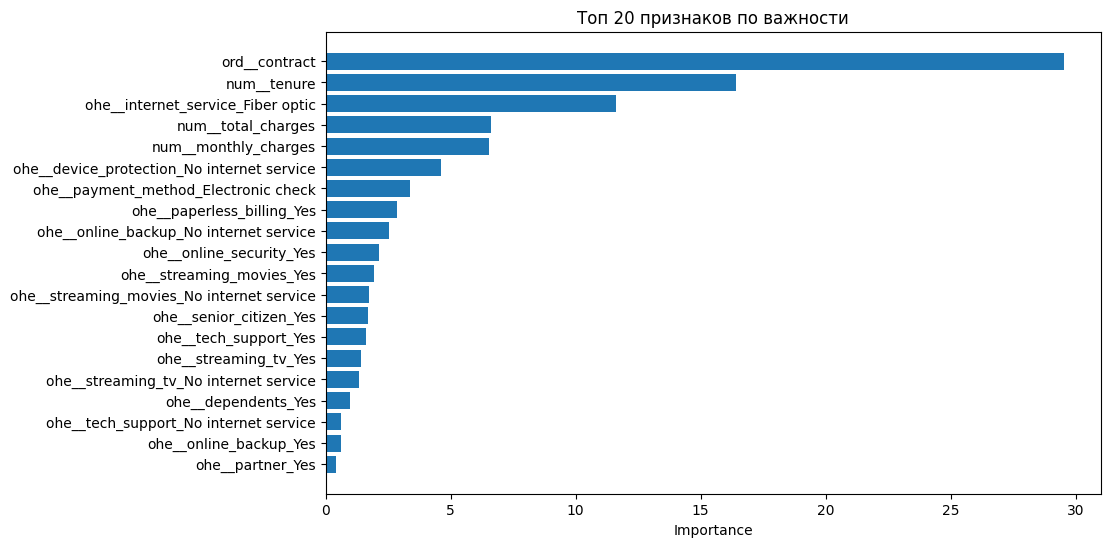

In [25]:
catboost_model = grid.best_estimator_.named_steps['models']

X_train_transformed = grid.best_estimator_.named_steps['preprocessor'].transform(X_train)

feature_names = list(grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out())

pool = Pool(X_train_transformed, label=y_train, feature_names=feature_names)

catboost_model.fit(pool, verbose=0)

feature_importances = catboost_model.get_feature_importance(prettified=True)

top_features = feature_importances.sort_values(by='Importances', ascending=False).head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature Id'], top_features['Importances'])
plt.gca().invert_yaxis()
plt.title('Топ 20 признаков по важности')
plt.xlabel('Importance')
plt.show()

In [26]:
N = 20  
top_features = feature_importances.sort_values(by='Importances', ascending=False).head(N)['Feature Id'].tolist()

X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)

X_top = X_train_df[top_features]

best_params = grid.best_params_
catboost_top = CatBoostClassifier(**{k.replace('models__', ''): v for k, v in best_params.items() if 'models__' in k}, verbose=0)

roc_auc_scores = cross_val_score(catboost_top, X_top, y_train, scoring='roc_auc', cv=3, n_jobs=-1)

print(f"🎯 ROC AUC после отбора топ-{N} признаков: {roc_auc_scores.mean():.4f}")

🎯 ROC AUC после отбора топ-20 признаков: 0.8498


✅ **Вывод:** Из всех признаков отобраны топ-20 наиболее важных. Они используются для обучения модели.

# 🎯 Оптимизация порога

In [27]:
catboost_top.fit(X_top, y_train, verbose=0)
y_train_proba = catboost_top.predict_proba(X_top)[:, 1]

thresholds = np.linspace(0.1, 0.9, 100)
results = []

for t in thresholds:
    y_pred = (y_train_proba >= t).astype(int)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    results.append((t, precision, recall, f1))

metrics_df = pd.DataFrame(results, columns=["threshold", "precision", "recall", "f1"])

filtered = metrics_df[metrics_df["precision"] >= 0.6]
best_row = filtered.sort_values(by="recall", ascending=False).iloc[0]
best_threshold = best_row["threshold"]

print(f"✅ Оптимальный порог: {best_threshold:.2f}")
print(f"Precision: {best_row['precision']:.4f}, Recall: {best_row['recall']:.4f}, F1: {best_row['f1']:.4f}")

✅ Оптимальный порог: 0.37
Precision: 0.6054, Recall: 0.7003, F1: 0.6494


🎯 **Вывод:** С использованием адаптированного порога модель стала лучше идентифицировать клиентов, которые с высокой вероятностью уйдут, сохраняя приемлемый уровень precision.

# ⚙️ Финальная модель

🚀 ROC-AUC на тестовой выборке (адаптированный порог): 0.8431


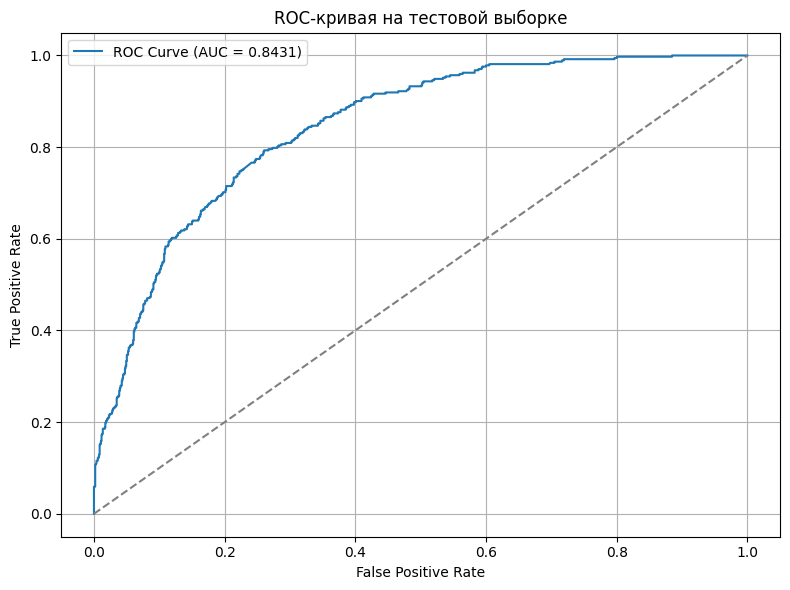

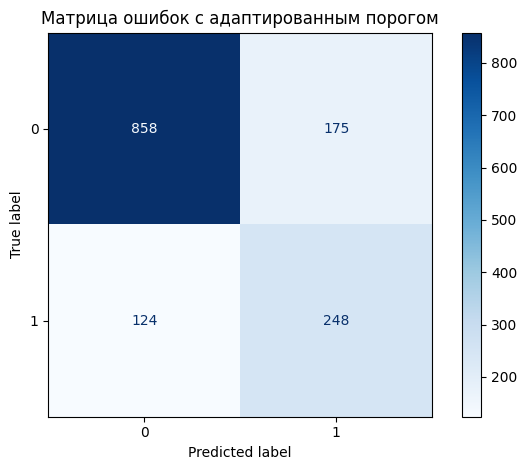

In [28]:
X_test_transformed = grid.best_estimator_.named_steps['preprocessor'].transform(X_test)
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)
X_test_top = X_test_df[top_features]

y_test_proba = catboost_top.predict_proba(X_test_top)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

roc_auc_test = roc_auc_score(y_test, y_test_proba)
print(f"🚀 ROC-AUC на тестовой выборке (адаптированный порог): {roc_auc_test:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_test:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая на тестовой выборке')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost_top.classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок с адаптированным порогом")
plt.tight_layout()
plt.show()

# 📌 Финальные выводы

- Был проведён полный цикл анализа оттока клиентов телеком-компании: от разведочного анализа до построения моделей.
- После обработки данных и отбора признаков была построена модель `CatBoostClassifier`, показывающая ROC-AUC на тесте **0.84**.
- Учтён дисбаланс классов и подобран оптимальный порог, минимизирующий ошибки второго рода (модель лучше нацелена на предсказывание уходящих клиентов).
- Наибольшую корреляцию с оттоком показывают признаки `contract`, `tenure`, `online_security`. Они больше всего влияют на предсказание.

📦 Итог: модель готова к использованию в продакшн-окружении для предсказания ухода клиентов и принятия соответствующих мер.